In [11]:
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os


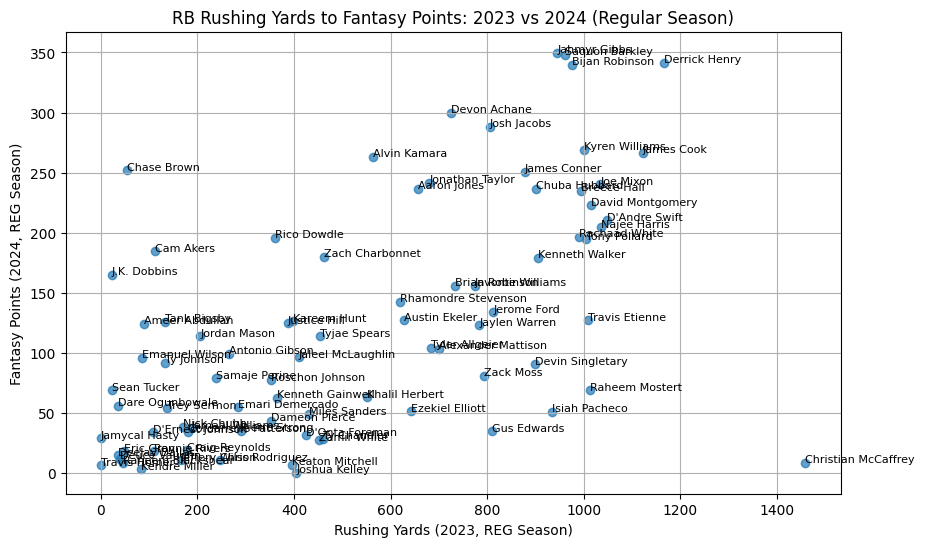

In [12]:
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

# Load offense dataset
wk_offense_df = pd.read_csv(path + "/weekly_player_stats_offense.csv")
yr_offense_df = pd.read_csv(path + "/yearly_player_stats_offense.csv")

# Restrict to RBs
rbs_df_weekly = wk_offense_df[(wk_offense_df["position"] == "RB") & (wk_offense_df["season_type"] == "REG")]
rbs_df = yr_offense_df[(yr_offense_df["position"] == "RB") & (yr_offense_df["season_type"] == "REG")]

# Get season totals for 2023 and 2024
rbs_2023 = rbs_df[rbs_df["season"] == 2023].groupby("player_name")["rushing_yards"].sum().reset_index()
rbs_2024 = rbs_df[rbs_df["season"] == 2024].groupby("player_name")["season_fantasy_points_ppr"].sum().reset_index()

# Merge on player name
rbs_compare = pd.merge(rbs_2023, rbs_2024, on="player_name", suffixes=("_2023", "_2024"))

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(rbs_compare["rushing_yards"], rbs_compare["season_fantasy_points_ppr"], alpha=0.7)

# Add labels for clarity
for _, row in rbs_compare.iterrows():
    plt.text(row["rushing_yards"], row["season_fantasy_points_ppr"], row["player_name"], fontsize=8)

plt.xlabel("Rushing Yards (2023, REG Season)")
plt.ylabel("Fantasy Points (2024, REG Season)")
plt.title("RB Rushing Yards to Fantasy Points: 2023 vs 2024 (Regular Season)")
plt.grid(True)

# Save the figure
os.makedirs('images', exist_ok=True)
plt.savefig('images/rb_rushing_yards_vs_fantasy_points.png', dpi=300, bbox_inches='tight')

plt.show()

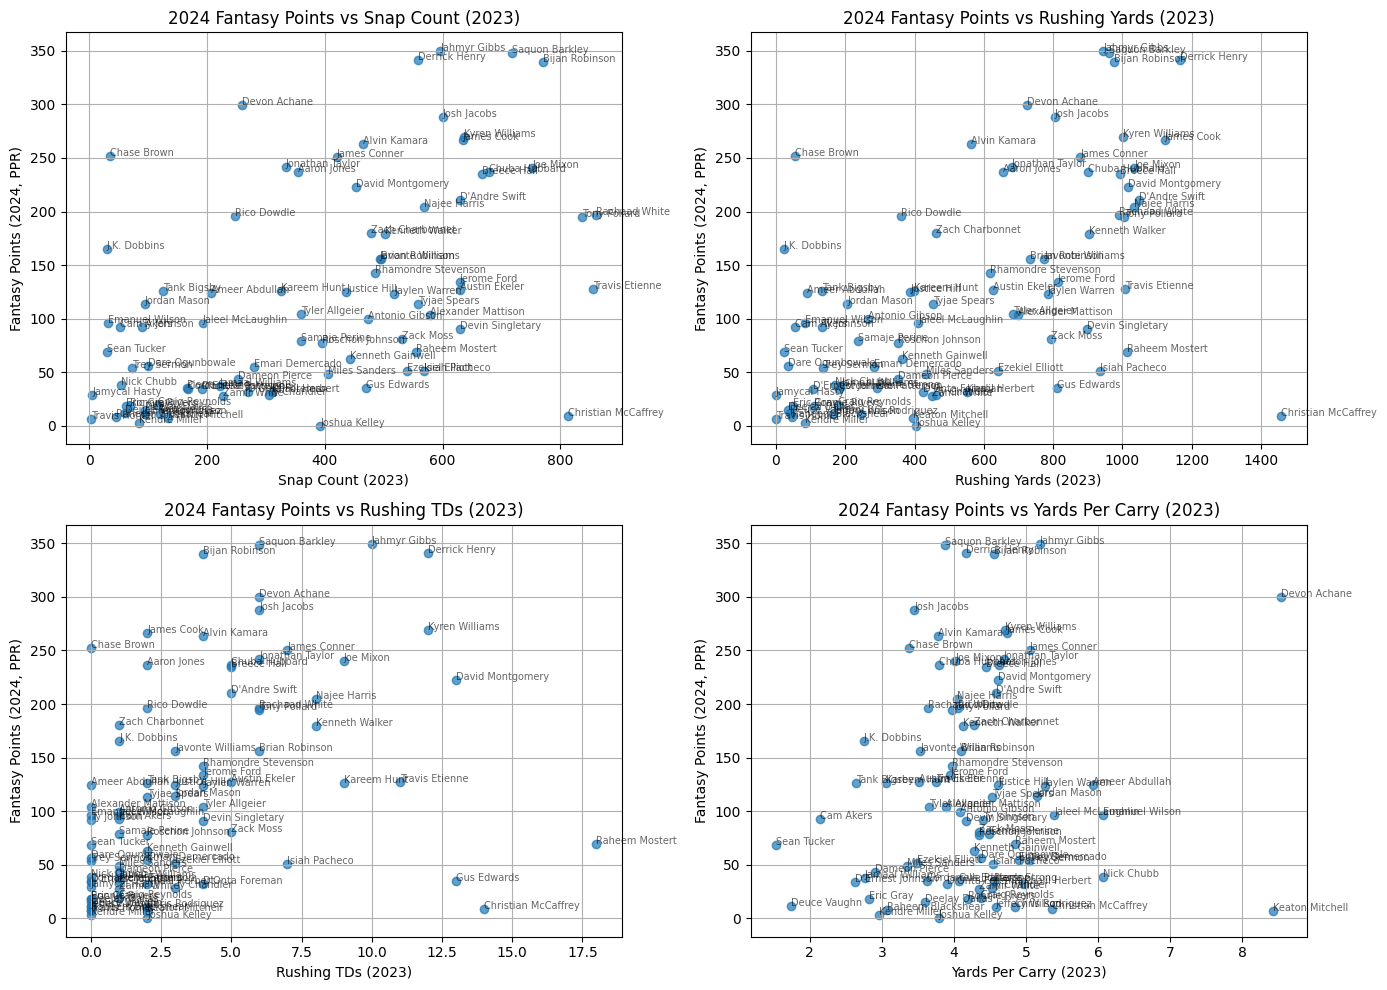

Index(['player_name', 'offense_snaps', 'rushing_yards', 'rush_touchdown',
       'ypc', 'season_fantasy_points_ppr_2023',
       'season_fantasy_points_ppr_2024'],
      dtype='object')


In [13]:
# Filter RB1 and RB2
rbs_2023 = rbs_df[(rbs_df["season"] == 2023)].copy()
rbs_2024 = rbs_df[(rbs_df["season"] == 2024)].copy()

rbs_2023 = rbs_2023.groupby("player_name", as_index=False).mean(numeric_only=True)
rbs_2024 = rbs_2024.groupby("player_name", as_index=False).mean(numeric_only=True)

# Merge on player_name
rbs_compare = pd.merge(
    rbs_2023[["player_name", "offense_snaps", "rushing_yards", "rush_touchdown", "ypc", "season_fantasy_points_ppr"]],
    rbs_2024[["player_name", "season_fantasy_points_ppr"]],
    on="player_name",
    how="inner",
    suffixes=("_2023", "_2024")   # 👈 distinguishes the years
)

# Define predictors
predictors = {
    "offense_snaps": "Snap Count (2023)",
    "rushing_yards": "Rushing Yards (2023)",
    "rush_touchdown": "Rushing TDs (2023)",
    "ypc": "Yards Per Carry (2023)"
}

# Make scatter plots
plt.figure(figsize=(14, 10))

for i, (col, label) in enumerate(predictors.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(rbs_compare[col], rbs_compare["season_fantasy_points_ppr_2024"], alpha=0.7)

    # Add labels for players
    for _, row in rbs_compare.iterrows():
        plt.text(row[col], row["season_fantasy_points_ppr_2024"], row["player_name"], fontsize=7, alpha=0.6)

    plt.xlabel(label)
    plt.ylabel("Fantasy Points (2024, PPR)")
    plt.title(f"2024 Fantasy Points vs {label}")
    plt.grid(True)

plt.tight_layout()

# Save the figure
os.makedirs('images', exist_ok=True)
plt.savefig('images/rb_feature_correlation.png', dpi=300, bbox_inches='tight')

plt.show()

print(rbs_compare.columns)

Now let's do Support Vector Regression on all these different variables and find which one has the best accuracy. 

Train RMSE: 69.9235350510531
Test RMSE: 97.7048996767983
Train R2: 0.47908500488083483
Test R2: -0.025677153402660302


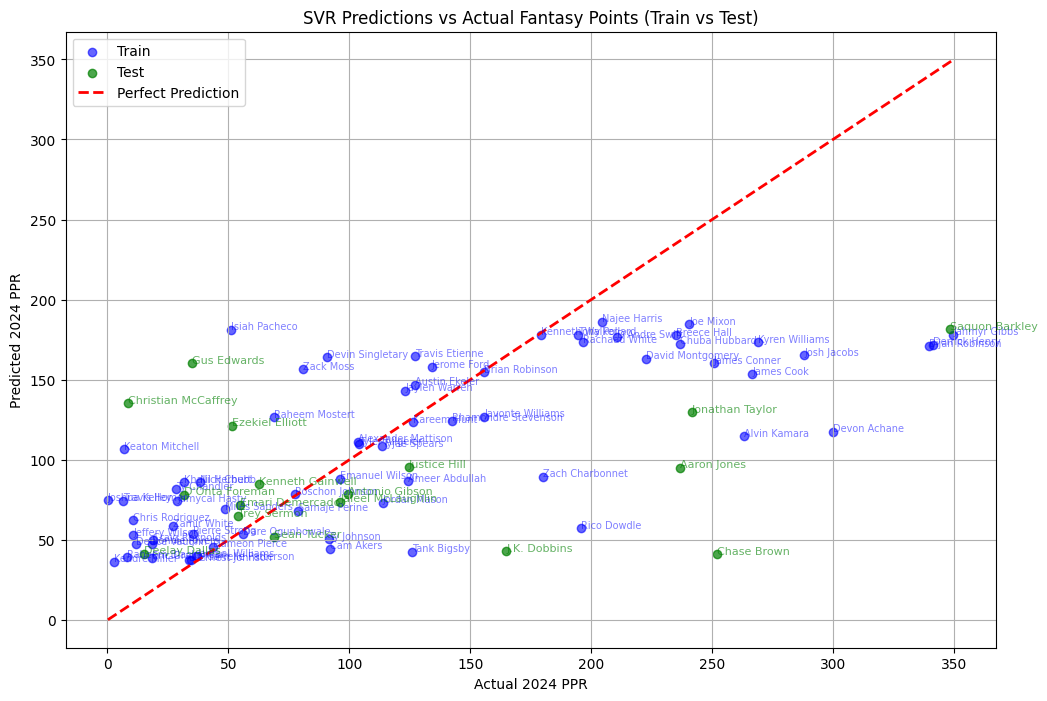

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define features (X) and target (y)
X = rbs_compare[["offense_snaps", "rushing_yards", "rush_touchdown", "ypc"]]
y = rbs_compare["season_fantasy_points_ppr_2024"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['ypc'] = X_train['ypc'].fillna(0)
X_test['ypc'] = X_test['ypc'].fillna(0)

# Scale features (important for SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR model
svr_model = SVR(kernel='rbf', C=10, epsilon=1.0)  # Hyperparameters can be tuned
svr_model.fit(X_train_scaled, y_train)


# Make predictions
y_train_pred = svr_model.predict(X_train_scaled)
y_test_pred = svr_model.predict(X_test_scaled)

# Evaluate performance
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

# Optional: visualize predictions vs true values
plt.figure(figsize=(12,8))

# Plot training points
player_names_train = rbs_compare.loc[y_train.index, "player_name"]
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, label='Train')

# Add labels for training points
for i, player in enumerate(player_names_train):
    plt.text(y_train.iloc[i], y_train_pred[i], player, fontsize=7, alpha=0.5, color='blue')

# Plot test points
player_names_test = rbs_compare.loc[y_test.index, "player_name"]
plt.scatter(y_test, y_test_pred, color='green', alpha=0.7, label='Test')

# Add labels for test points
for i, player in enumerate(player_names_test):
    plt.text(y_test.iloc[i], y_test_pred[i], player, fontsize=8, alpha=0.6, color='green')

# Reference line (perfect prediction)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual 2024 PPR")
plt.ylabel("Predicted 2024 PPR")
plt.title("SVR Predictions vs Actual Fantasy Points (Train vs Test)")
plt.legend()
plt.grid(True)

# Save the figure
os.makedirs('images', exist_ok=True)
plt.savefig('images/svr_model_performance.png', dpi=300, bbox_inches='tight')

plt.show()

# Interpretation

## Points on the line:

 - The model predicted the fantasy points exactly right.

## Points above the line:

 - Predicted points are higher than actual → the model overestimates the player’s points.

## Points below the line:

 - Predicted points are lower than actual → the model underestimates the player’s points.

On the fitting graph, our model would likely be in the range above the 

Train RMSE: 85.32755327031286
Test RMSE: 71.48681447974683
Train R2: 0.235445473684757
Test R2: 0.28630580305958353


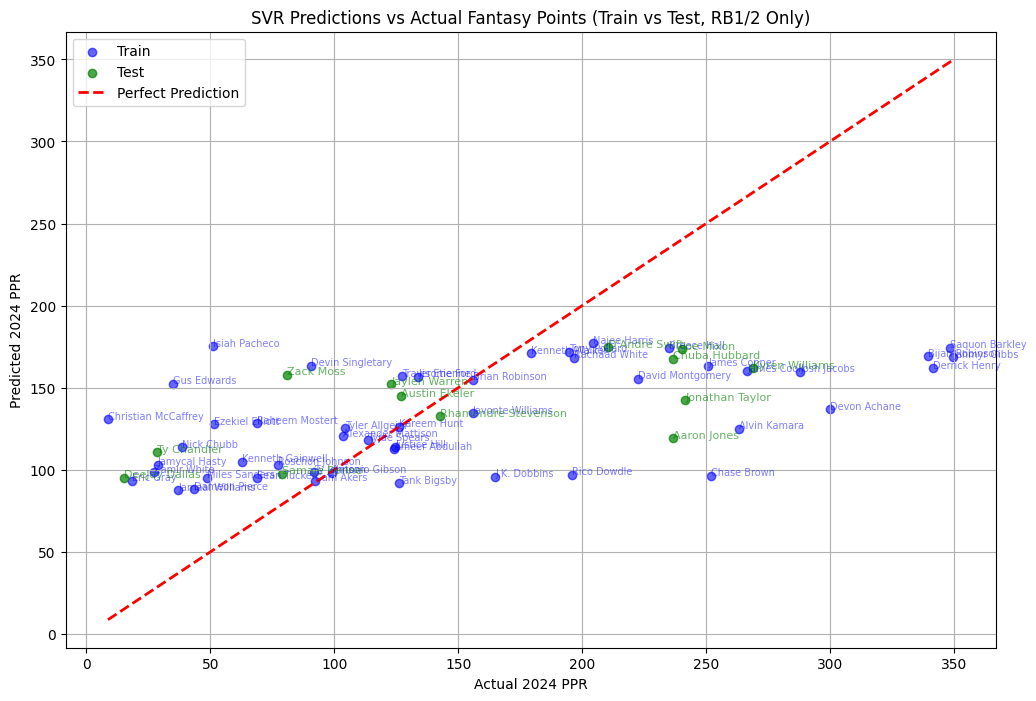

In [15]:
# Filter for RB1 or RB2 in 2023 or 2024
rbs_compare_filtered = pd.merge(
    rbs_2023[["player_name", "offense_snaps", "rushing_yards", "rush_touchdown", "ypc", "season_fantasy_points_ppr", "depth_team"]],
    rbs_2024[["player_name", "season_fantasy_points_ppr", "depth_team"]],
    on="player_name",
    how="inner",
    suffixes=("_2023", "_2024")  # distinguishes the years
)

rbs_compare_filtered = rbs_compare_filtered[
    (rbs_compare_filtered["depth_team_2023"] < 3) & (rbs_compare_filtered["depth_team_2024"] < 3)
].copy()

# Define features (X) and target (y)
X = rbs_compare_filtered[["offense_snaps", "rushing_yards", "rush_touchdown", "ypc"]]
y = rbs_compare_filtered["season_fantasy_points_ppr_2024"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fill NaNs
X_train['ypc'] = X_train['ypc'].fillna(0)
X_test['ypc'] = X_test['ypc'].fillna(0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR model
svr_model = SVR(kernel='rbf', C=10, epsilon=1.0)
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = svr_model.predict(X_train_scaled)
y_test_pred = svr_model.predict(X_test_scaled)

# Evaluate performance
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

# Plot
plt.figure(figsize=(12,8))

# Training points
player_names_train = rbs_compare_filtered.loc[y_train.index, "player_name"]
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, label='Train')
for i, player in enumerate(player_names_train):
    plt.text(y_train.iloc[i], y_train_pred[i], player, fontsize=7, alpha=0.5, color='blue')

# Test points
player_names_test = rbs_compare_filtered.loc[y_test.index, "player_name"]
plt.scatter(y_test, y_test_pred, color='green', alpha=0.7, label='Test')
for i, player in enumerate(player_names_test):
    plt.text(y_test.iloc[i], y_test_pred[i], player, fontsize=8, alpha=0.6, color='green')

# Perfect prediction line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual 2024 PPR")
plt.ylabel("Predicted 2024 PPR")
plt.title("SVR Predictions vs Actual Fantasy Points (Train vs Test, RB1/2 Only)")
plt.legend()
plt.grid(True)

# Save the figure
os.makedirs('images', exist_ok=True)
plt.savefig('images/rb_filtered_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

params = {
    'C': [1, 10, 50, 100],
    'epsilon': [0.1, 0.5, 1.0],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

grid = GridSearchCV(SVR(), params, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)
print(grid.best_score_)


{'C': 10, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
-0.43496184051329145
